In [2]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import pertpy as pt # an important dependency of sccoda


/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Single cell data offers the unique opportunity to model cell composition changes due to treatment. This is especially helpful when we assess a dataset of embryonic development where cell differentiation occurs.
Single cell data is compositional as inevitably it does not contain all cells from an organ or embryoid body (e.g. many cells are lost during sequencing and QC control) but a snapshot which contains some proportions of cell types which we hope correspond roughly to reality. 
However relative cell abundancies come with the trait that they all sum to zero. Hence, when one population goes up in size, another goes down which is an artifact that could confound real measurement of treatment effects on the cell composition of the data.
In this notebook we 
1. Subset data to desired number of conditions (datasets in our case) to compare
2. Make pseudoreplicates (without pseudobulking)
3. Determine reference cell type and design formula
4. Run compositional analysis with scCODA.

scCODA is an microbiome-inspired model (as microbial data is also compositional and also can consist of single cells/colonies) which uses joint modelling of all measured cell-type proportions, to account for the negative correlation bias and other confounders. As the changes in cell type composition is a mathematical problem whcich does not yield unique solutions, a single reference cell type is chosen to derive compositional changes.
It is important to note that scCODA models changes in mean abundance of cell types but does not account for the way different cells can respond to treatment in a different manner.

In [3]:
import sccoda # for those using conda environment sccoda is only available with pip

In [23]:
alldata = sc.read_h5ad('Anndata_Objects/Annotation/alldata.h5ad') #Anndata_Objects/Annotation/ 
alldata = alldata [:, ~alldata.var_names.duplicated(keep='first')].copy()
alldata.obs_names_make_unique()

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
alldata

AnnData object with n_obs × n_vars = 63324 × 18071
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'leiden_res0.5', 'leiden_res2', 'scVI_res_0.5', 'manual_celltype_annotation'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'leiden_res0.5', 'leiden_res2', 'leiden_r

In [47]:
alldata = alldata[alldata.obs['manual_celltype_annotation'] != 'Contamination'].copy()

Optionally change labels to ones easy to visualise

In [48]:

labels = {
    '0': 'Pluripotent',
    '1': 'Cardiac Mesoderm',
    '2': 'Early Neurons',
    '3': 'Primitive Streak',
    '4': 'Pluripotent',
    '5': 'Pre-Neurons',
    '6': 'GR Pluripotent',
    '7': 'Mesoderm',
    '8': 'GR Pluripotent',
    '9': 'Epidermis',
    '10': 'Hemangioblasts',
    '11': 'N/A1',
    '12': 'N/A2',
    '13': 'N/A3',
    '14': 'N/A4',
    '15': 'Endoderm',
    '16': 'Contamination'
}
alldata.obs['manual_celltype_annotation'] = alldata.obs['scVI_res_0.5'].map(labels)

In [25]:
fig, ax = plt.subplots(figsize=(4,3))
sc.pl.umap(alldata_subset, color=['manual_celltype_annotation'], ax=ax, show=False)
ax.set_title(f'Annotation for Compositional Analysis', fontsize=12, weight='bold')
plt.savefig(f'new_data/plots/compositional/Compositional_annotation.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# also in 10_Differential_Expression_pseudobulk.ipynb
def subset_data(alldata, samples): 
    new = alldata[alldata.obs['sample'].isin(samples),:].copy()
    sc.pp.filter_genes(new, min_cells = 10)
    return new

Optional, plot the individual conditions on embeddings to view their cell distribution

In [ ]:
for sample in samples:
    alldata_subset=subset_data(alldata, [sample])
    fig, ax = plt.subplots(figsize=(4,3))
    sc.pl.umap(alldata_subset, color=['manual_celltype_annotation'], ax=ax, show=False)
    ax.set_title(f'{sample}', fontsize=12, weight='bold')
    plt.show()

In [7]:
list(alldata.obs['sample'].unique())

['ESLIF',
 '2i',
 '20_nM_RA',
 '5000_nM_RA',
 'EB_8d',
 'EB_2d',
 'HD_8d',
 'HD_2d',
 'RA_7d',
 'RA_0d']

Generally subset to conditions which have the cell types of interest and have sufficient variety of cell types. Also so 
that one can choose a suitable reference cell type (e.g. the cell type that must have unchanged abundance across the conditions)

In [72]:
samples=['20_nM_RA', '5000_nM_RA']

alldata_subset=subset_data(alldata, samples)

In [ ]:
alldata_subset.obs['manual_celltype_annotation'].unique()

In our data batch and protocol were confounding covariates. Batch was accounted for during integration but protocol is not; e.g. when we include in compositional analysis samples grown in different grown medium we include protocol as a covariate even though scCODA does not have the most robust covariate modeling (e.g. it assumes linear relationship between covariates)

In [61]:
# in case there is another covariate one is interested in and it is not recorded in .obs
labels_pr= {
    'EB_8d': 'protocol1',
    'HD_8d': 'protocol1',
    'RA_7d': 'protocol2',
    '20_nM_RA': 'protocol2',
    '5000_nM_RA': 'protocol2'
}

alldata_subset.obs['protocol'] = alldata_subset.obs['sample'].map(labels_pr)

We initialise the sccoda model

In [73]:
sccoda_model = pt.tl.Sccoda() 

In [ ]:
alldata

We define the function for pseudoreplicate creation which is similar to the one in the Differential Expression notebook but does not create pseudobulks.
For clarity: in our dataset condition is called sample. However, generally in experimental design sample can refer to a replicate within a condition. This is what it is called in scCODA. It is good to keep in mind that here for our dataset sample means condition and replicate means sample.

In [13]:
    # IMPORTANT: Code block by Sanbomics (GitHub: mousepixels), M. Sanbouw (2023). Docstring and modifications by mariakaraboeva, for readability
    # and modified by mariakaraboeva for the goals of the analysis.

def pseudoreplicates(cell_subset, n, condition, labels):
    '''
    Creates pseudoreplicates that will serve as the samples which the scCODA algorithm needs, for example 10 samples per condition (with no less than
    200 cells). Every pseudoreplicate has a unique name. There should always be unique combinations of batch-condition-pseudoreplicate name in the .obs
    for scCODA to work. The pseudoreplicates are not pseudobulked.

    Args:
        cell_subset (Anndata object):
        n (int): number of pseudoreplicates. This function is optimised tom ake the same number of pseudoreplicates for all conditions each
        condition (str): the .obs name of the condition column
        labels (str): name of cell type labels in .obs

    Returns:
        list:  list of Anndata objects, non-pseudobulked, with an .obs column containing the pseudoreplicate annotations
        
    '''
    
    psreplicates_all_conds = [] # to store anndata objects with pseudoreplicates
    for c in cell_subset.obs[condition].unique(): 
        cond_cell_subset = cell_subset[cell_subset.obs[condition] == c] # we make pseudoreplicates for each condition
        
        #get all cell indices in order to shuffle them
        indices = list(cond_cell_subset.obs_names) 
        random.seed(4)
        random.shuffle(indices)
        #then split the cells into n groups which will be the pseudoreplicate number
        indices = np.array_split(np.array(indices), n) 
        # we create the condition-based anndata which contains the pseudoreplicates
        for i, pseudo_rep in enumerate(indices): 
            psrep_adata = cond_cell_subset[pseudo_rep].copy()
            obs_subset = cond_cell_subset.obs.loc[pseudo_rep]
            psrep_adata.obs = obs_subset.copy()
            psrep_adata.obs['replicate'] = f"{c}_{i}"
            psrep_adata.obs[labels]=cond_cell_subset.obs[labels]
            #add all condition-based anndata objects to a list
            psreplicates_all_conds.append(psrep_adata) 
    return psreplicates_all_conds



In [14]:
import random

In [74]:
coda=pseudoreplicates(alldata_subset, 10, 'sample', 'manual_celltype_annotation')

In [ ]:
coda

In [75]:
adata = sc.concat(coda) #back to concatenated obj with all conditions

In [ ]:
adata.X

In order to check whether there are only unique combinations of sample batch and replicate (or other .obs columns). In the output table there should be only values of 1 (how many times a combination appears)

In [1]:
# adata.obs.groupby("replicate")[["sample", "batch"]].nunique() 

In [ ]:
adata.obs['replicate'] 

Setting up the model with our object. It outputs a MuData object (multimodal data) which contains two modalities: One of the dataset with cell number and gene counts and one with pseudobulks created with scCODA and cell type abundancies as features.

In [76]:
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level", 
    generate_sample_level=True, #scCODA assembles sample-level data: basically pseudobulks from the pseudoreplicates
    cell_type_identifier="manual_celltype_annotation",
    sample_identifier="replicate", # sample identifier is replicate identifier
    covariate_obs=["sample"], # doesnt take "real" formulas, models these independently and equally
)
sccoda_data 

MuData object with n_obs × n_vars = 19578 × 17967
  2 modalities
    rna:	19558 x 17953
      obs:	'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'batch', 'leiden_res0.5', 'leiden_res2', 'scVI_res_0.5', 'manual_celltype_annotation', 'replicate', 'scCODA_sample_id'
      obsm:	'Scanorama', 'X_pca', 'X_pca_harmony', 'X_scVI', 'X_umap'
      layers:	'log1p_norm', 'norm'
    coda:	20 x 14
      obs:	'sample', 'replicate'
      var:	'n_cells'

Make plots representing the proportions in the data prior to compositional analysis in order to identify a reference cell type
that does not change much in abundance. The plots are made of cell proportions for each covariate (e.g. the cells grouped by batch have
different proportions within each batch than grouped by condition)
From here we find that across covariates a cell type with relatively constant abundance is N/A3

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/pertpy/tools/_coda/_base_coda.py:1678: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cell_types, rotation=90)


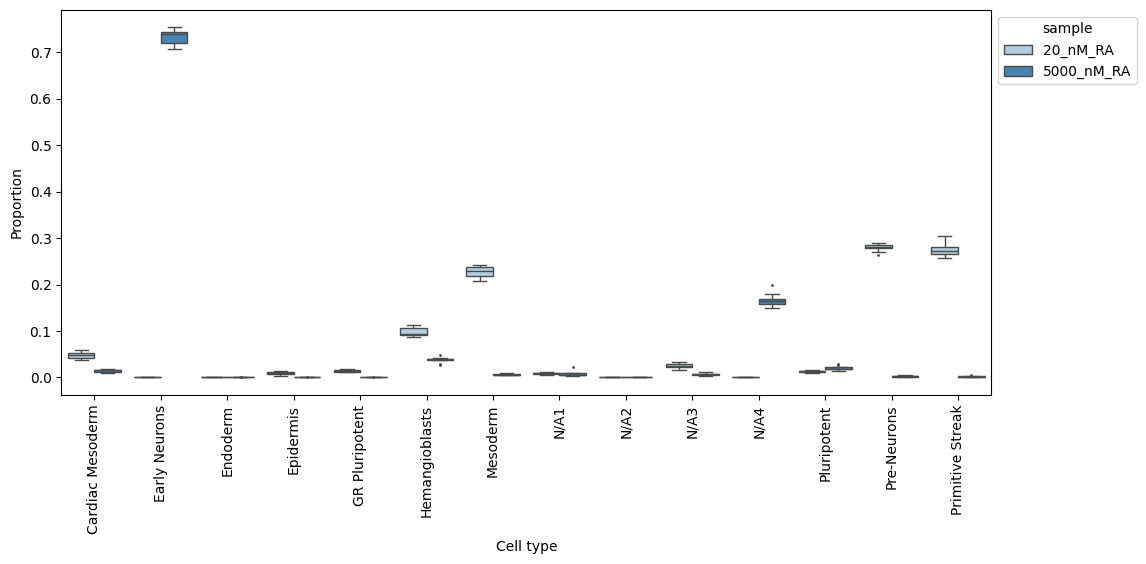

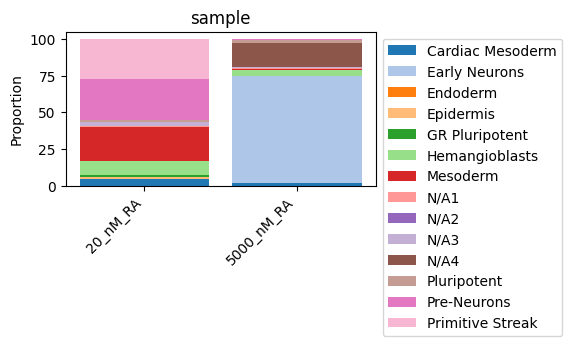

In [77]:

sccoda_model.plot_boxplots(
    sccoda_data,
    modality_key="coda",
    feature_name="sample",
    figsize=(12, 5),
    add_dots=False
)
plt.show()

sccoda_model.plot_stacked_barplot(
    sccoda_data, modality_key="coda", feature_name="sample", figsize=(4, 2)
)
plt.show()

In [ ]:
sccoda_data = sccoda_model.prepare(
    sccoda_data,
    modality_key="coda",
    formula="sample",
    reference_cell_type="Pluripotent",
)
sccoda_model.run_nuts(sccoda_data, modality_key="coda", rng_key=1234) #rng_key for reproducibility

• Zero counts encountered in data! Added a pseudocount of 0.5.


sample:  10%|███▌                                | 1100/11000 [01:08<14:57, 11.02it/s, 1023 steps of size 1.75e-03. acc. prob=0.99]

View the results as stored in the object

In [ ]:
sccoda_data["coda"].varm 

In [ ]:
sccoda_data

Choosing the FDR (False Discovery Rate) cutoff

In [ ]:
sccoda_model.set_fdr(sccoda_data, 0.02) 

In [68]:
sccoda_file=sccoda_model.credible_effects(sccoda_data, modality_key="coda")

In [69]:
sccoda_file.to_csv('sccoda_protocol/sscoda_sample_5000vs20_pluripotent_ref_type.csv')

Visualise changes in proportions. Always compared to a reference condition (or other covariate representative). Not all "possible" pairs of comparisons 
are shown due to this. But any such comparisons can be inferred by simple substraction of the effects. 
scCODA outputs slightly different results every time it is run. The comparison 5000_nM_RA vs 20_nM_RA seemed to yield the most consistent results, even across different designs.

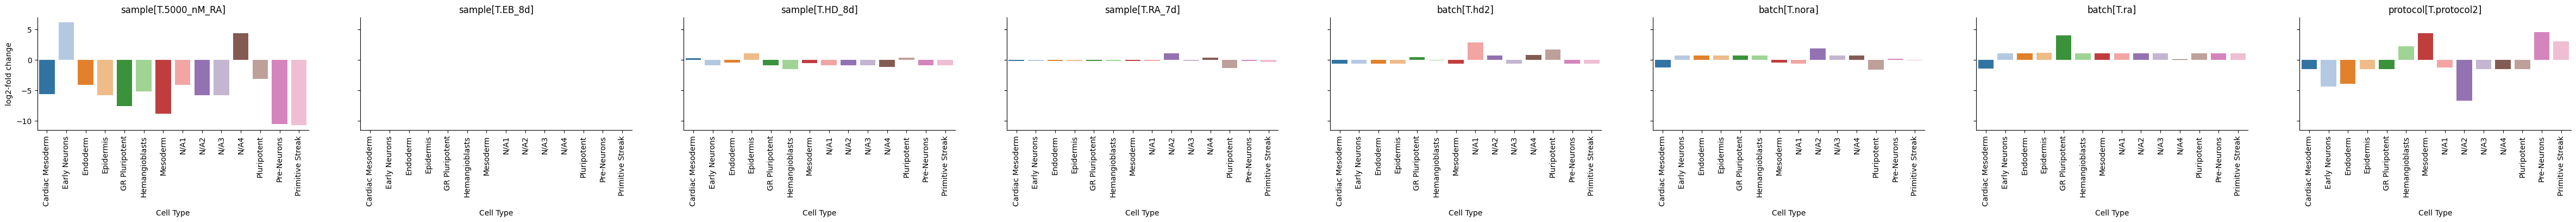

In [70]:

sccoda_model.plot_effects_barplot(sccoda_data)


References:
1. Büttner, M., Ostner, J., Müller, C.L. et al. scCODA is a Bayesian model for compositional single-cell data analysis. Nat Commun 12, 6876 (2021). https://doi.org/10.1038/s41467-021-27150-6
2. Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). https://doi.org/10.1038/s41576-023-00586-w